##### Data of experimentally validated molecules and additional molecules with machine learning-predicted and theoretically validated voltage values, as reported in the literature

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_raw_All = pd.read_csv('OrganicElectrodesAll.csv')

In [3]:
df_raw_All.shape

(1857, 2)

In [4]:
df_All = df_raw_All.drop_duplicates(subset='SMILES', keep='first')

In [5]:
df_All.shape

(1817, 2)

- To sanitize SMILES strings in an RDKit-compatible format, use RDKit to process each SMILES string and filter out those that fail the sanitization process.

In [6]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles

# Function to sanitize SMILES strings
def sanitize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is not None:
            # Return canonical SMILES if sanitization is successful
            return MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None


In [8]:
# Ensure df_All is a new DataFrame and not a view of another DataFrame
df_All = df_All.copy()

# Apply sanitization to the SMILES column and store the result using loc
df_All.loc[:, 'smiles'] = df_All['SMILES'].apply(sanitize_smiles)

# Filter out rows with invalid SMILES using loc
df_All = df_All.loc[df_All['smiles'].notna()]


In [9]:
df_All.shape

(1817, 3)

In [10]:
df_All.head()

,Voltage,SMILES,smiles
0,2.95,O=C1C2=C(O)C=CC(O)=C2C(=O)C2=C1C(=O)C1=C(C2=O)...,O=c1c2c(O)ccc(O)c2c(=O)c2c(=O)c3c(=O)c4c(=O)c5...
1,2.40,O=C(C1=C(C(S(=O)(O[Na])=O)=CC=C1)C2=O)C3=C2C=C...,O=C1c2cccc(S(=O)(=O)O[Na])c2C(=O)c2cccc(S(=O)(...
2,2.40,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C(S(=O)(O)=O)=C...,O=S(=O)(O)c1cccc2c(O)c3c(S(=O)(=O)O)cccc3c(O)c12
3,2.25,O=C1C2=C(C=CC=C2)C(=O)C2=C1C=CC=C2S(=O)(=O)O[Na],O=C1c2ccccc2C(=O)c2c1cccc2S(=O)(=O)O[Na]
4,2.25,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C=CC=C3)=C2O,O=S(=O)(O)c1cccc2c(O)c3ccccc3c(O)c12


### Data augmentation on train dataset

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Step 1: Split data using StratifiedShuffleSplit
# Example binning of voltage values
bins = [0, 1.9, 2.7, 3.5, 5]  # Adjust based on your data range
labels = ['very low', 'low', 'medium', 'high']
df_All['Voltage_Binned'] = pd.cut(df_All['Voltage'], bins=bins, labels=labels)

# Perform stratified split using the binned voltage column
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df_All, df_All['Voltage_Binned']):
    train_df = df_All.iloc[train_index]
    test_df = df_All.iloc[test_index]


In [38]:
train_df.to_csv('train_df_Agmt_Rdkit.csv', index=False)
test_df.to_csv('test_df_Agmt_Rdkit.csv', index=False)

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Function to generate different SMILES representations
def generate_smiles_variants(smiles, num_variants=5):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []  # Return an empty list if the SMILES string is invalid

    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate conformers
    AllChem.EmbedMolecule(mol, randomSeed=42)  # Ensure reproducibility

    # Generate different canonical SMILES by modifying the molecule
    smiles_variants = set()
    for _ in range(num_variants):
        # Generate a new conformer
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  # Add hydrogens to the new molecule
        AllChem.EmbedMolecule(mol, randomSeed=42)  # Generate new conformer
        
        # Generate non-canonical SMILES
        new_smiles = Chem.MolToSmiles(mol, canonical=False)
        smiles_variants.add(new_smiles)
    
    return list(smiles_variants)

# Initialize a list to store rows for the augmented dataframe
rows = []

# Iterate over each row and generate variants
for index, row in train_df.iterrows():
    smiles = row['SMILES']
    voltage = row['Voltage']
    variants = generate_smiles_variants(smiles)
    for variant in variants:
        rows.append({'SMILES': variant, 'Voltage': voltage})

# Convert list of rows to DataFrame
augmented_df = pd.DataFrame(rows)

# Save augmented dataframe
augmented_df.to_csv('augmented_df_All_Rdkit.csv', index=False)


[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[17:34:56] UFFTYPER: Warning: hybridization set to SP3 for atom 4


In [2]:
# Import saved files when needed
train_df = pd.read_csv('train_df_Agmt_Rdkit.csv')
test_df = pd.read_csv('test_df_Agmt_Rdkit.csv')
augmented_df = pd.read_csv('augmented_df_All_Rdkit.csv')

In [41]:
augmented_df.shape

(1453, 2)

In [42]:
augmented_df.head()

,SMILES,Voltage
0,N#CC(C#N)=c1c([H])c([H])c(=C(C#N)C#N)c([H])c1[H],2.800000
1,C(c1c(C([H])([H])[H])c(=O)nc2c(n1)OC(=O)C(=O)C...,3.122500
2,Clc1c([H])c(Cl)c(Cl)c2c1/C(=N/S(=O)(=O)C([H])(...,2.568714
3,O=C1c2c([H])c([H])c3c4c([H])c([H])c5c6c(c([H])...,3.700000
4,N#CC(C#N)=C1C([H])=C([H])C(C(C#N)(C#N)[H])([H]...,2.900000


In [43]:
train_df.head()

,Voltage,SMILES,smiles,Voltage_Binned
0,2.800000,N#CC(C#N)=C1C=CC(=C(C#N)C#N)C=C1,N#CC(C#N)=c1ccc(=C(C#N)C#N)cc1,medium
1,3.122500,CC1=C(C)C(=O)N=C2C(=O)C(=O)C(=O)OC2=N1,Cc1nc2c(nc(=O)c1C)C(=O)C(=O)C(=O)O2,medium
2,2.568714,Clc1cc(Cl)c(Cl)c(C\2=N\S(=O)(=O)C)c1C(=N\S(=O)...,CS(=O)(=O)/N=C1/c2c(Cl)cc(Cl)c(Cl)c2/C(=N/S(C)...,low
3,3.700000,O=C1C2=CC=C3C4=CC=C5C(N(C(C6=C5C4=C(C7=C3C2=C(...,O=C1c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C(=O)N1c1c...,high
4,2.900000,N#CC(C#N)=C1C=CC(C(C#N)C#N)C=C1,N#CC(C#N)=C1C=CC(C(C#N)C#N)C=C1,medium


In [44]:
train_df.shape

(1453, 4)

In [45]:
test_df.shape

(364, 4)

In [46]:
# Delete 'Voltage_Binned' column from both train_df and test_df
train_df = train_df.drop(columns=['Voltage_Binned'])
test_df = test_df.drop(columns=['Voltage_Binned'])

In [47]:

# Merge augmented data with original train data and test data
augmented_df['Augmented'] = 1
train_df['Augmented'] = 1
test_df['Augmented'] = 0
df_All_augmented = pd.concat([augmented_df,train_df, test_df], ignore_index=True)


In [48]:
df_All_augmented.head()

,SMILES,Voltage,Augmented,smiles
0,N#CC(C#N)=c1c([H])c([H])c(=C(C#N)C#N)c([H])c1[H],2.800000,1,NaN
1,C(c1c(C([H])([H])[H])c(=O)nc2c(n1)OC(=O)C(=O)C...,3.122500,1,NaN
2,Clc1c([H])c(Cl)c(Cl)c2c1/C(=N/S(=O)(=O)C([H])(...,2.568714,1,NaN
3,O=C1c2c([H])c([H])c3c4c([H])c([H])c5c6c(c([H])...,3.700000,1,NaN
4,N#CC(C#N)=C1C([H])=C([H])C(C(C#N)(C#N)[H])([H]...,2.900000,1,NaN


In [49]:
df_All_augmented.shape

(3270, 4)

In [50]:
df_All_augmented = df_All_augmented.drop_duplicates(subset='SMILES', keep='first')

In [51]:
df_All_augmented.shape

(3251, 4)

In [52]:
df_All = df_All_augmented.copy()

In [53]:
df_All.shape

(3251, 4)

### Exploratory Data Analysis (EDA)

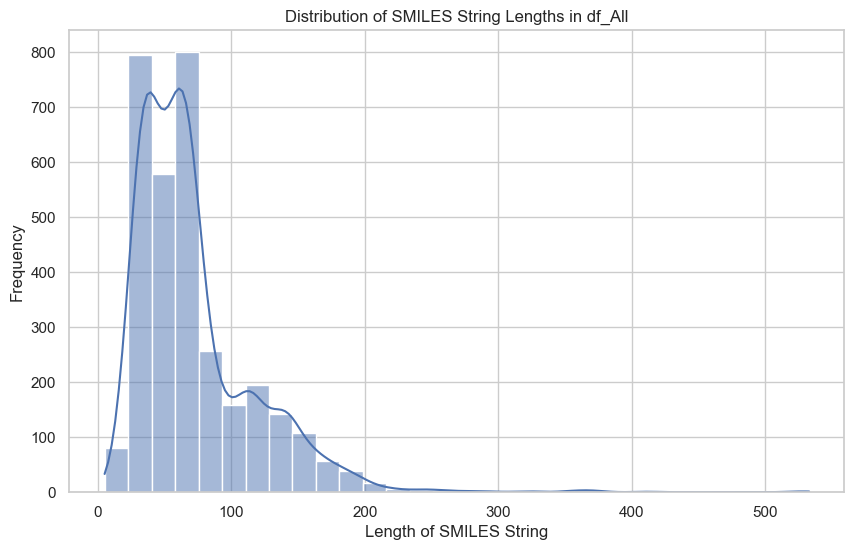

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each SMILES string
df_All['length'] = df_All['SMILES'].apply(len)

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_All['length'], bins=30, kde=True)

# Set the plot title and labels
plt.title('Distribution of SMILES String Lengths in df_All')
plt.xlabel('Length of SMILES String')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [55]:
max_length_All = df_All['SMILES'].apply(len).max()

print("The maximum length of SMILES strings in the df_All DataFrame is:", max_length_All)

The maximum length of SMILES strings in the df_All DataFrame is: 533


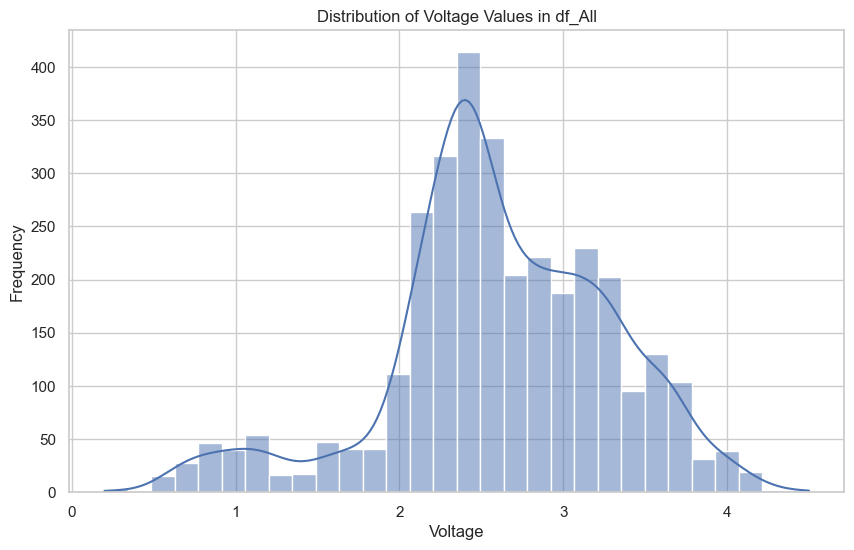

In [56]:
# Create the plot for Voltage distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_All['Voltage'], bins=30, kde=True)
plt.title('Distribution of Voltage Values in df_All')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.show()